<a href="https://colab.research.google.com/github/aggelostais/machine_learning_learning_path/blob/main/Intro_Large_Language_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

![alt text](https://events.grnet.gr/event/164/images/177-Module%202%20wide.png)

https://events.grnet.gr/event/164/overview

---
Throughout the code we will be having hints how to run it on HPC, starting with the **[HPC]** flag.

---

## Environment Variables
we will need to use Environment Variables:
- HF_TOKEN is you huggingface token, you may generate one on this url: https://huggingface.co/settings/tokens

## [HPC] On Linux do:
- `nano ~/.bashrc`
- `export HF_TOKEN="..."`
- `source ~/.bashrc`
- `echo $HF_TOKEN`




We will use Llama-3.2-1B-Instruct. In order to be able to download it you will need to accept the terms of use on the following link:

https://huggingface.co/meta-llama/Llama-3.2-1B-Instruct

You can check if you have been granted on:

https://huggingface.co/settings/gated-repos

# [HPC] Install dependencies
- `pip install transformers`
- `pip install accelerate`
- `pip install --upgrade jinja2`
- `pip install -U sentence-transformers`
- `pip install pandas`
- `pip install numpy`
- `pip install scikit-learn`

# [HPC] Allocation of resources
- `salloc -A pXYZ -p gpu --qos default -N 1 -t 08:00:00`
- `salloc -A pXYZ -p gpu --qos default -N 1 -t 08:00:00 --gres=gpu:1`
- Then, if you use vscode, do shift+enter on the python file. This will open a new terminal.
- In the new terminal, do ctrl+z to stop the python script.
- You need to do ssh on the allocated node. Get the node name from the previous terminal, after @ (`<username>@<node_name>`) and then do `ssh <node_name>` in the new terminal.
- On MeluXina you will need to load: `ml PyTorch/2.1.2-foss-2023a-CUDA-12.1.1`
- And then: `CUDA_VISIBLE_DEVICES="0,1,2,3" python` or `CUDA_VISIBLE_DEVICES="0" python`
- Python should be launched now and you may run interactively your script.

# [HPC] Usefull Commands
- In the first terminal, you can do the following to monitor the resources:
- `watch -n 1 "top -bn1 | head -n 15 && nvidia-smi"`
- `du -sh .`
- `lfs quota -u uXXX`
- `lfs quota /mnt/tier1/project/pYYY`
- `watch nvidia-smi --query-compute-apps=pid,process_name,used_memory,gpu_name --format=csv`
- `watch nvidia-smi --query-gpu=memory.total,memory.used,memory.free --format=csv`
- `scancel <pid>`
- `kill -9 <pid>`

# Import libraries

https://huggingface.co/docs/transformers/index

In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer, TextStreamer, pipeline
import os
import torch
import time
import re

In [4]:
import getpass
os.environ['HF_TOKEN'] = getpass.getpass("Enter the value for HF_TOKEN: ")

Enter the value for HF_TOKEN: ··········


## HF_HOME is the directory where you want to save models' weights.

## [HPC] use the project's directory and not the user's one, so as to have more space.
e.g.

> mkdir /mnt/tier1/project/pXYZ/HF_cache

> cd /mnt/tier1/project/pXYZ/HF_cache

export $HF_HOME as well.

In [ ]:
os.environ["HF_HOME"] = "/content/my_huggingface_cache"

# The Transformers Library

## Download Models

In [ ]:
my_model = "meta-llama/Llama-3.2-1B-Instruct"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(my_model,
                                          token=os.environ["HF_TOKEN"],
                                          cache_dir=os.environ["HF_HOME"])

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

In [ ]:
model = AutoModelForCausalLM.from_pretrained(   my_model,
                                                token=os.environ["HF_TOKEN"],
                                                cache_dir=os.environ["HF_HOME"],
                                                device_map="auto")

config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

## pad token

In [ ]:
# Depending on the model, the pad token might not be defined
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    print("Pad token was None, so it was set to eos token.")

Pad token was None, so it was set to eos token.


## Streamer for model.generate and pipeline

In [ ]:
streamer = TextStreamer(tokenizer)

## Messages

In [ ]:
system_instructions = f"You are a helpful assistant."
my_messages = [{"role": "system", "content": system_instructions}]
my_prompt = """Is reality real?"""
my_messages.append({"role": "user", "content": my_prompt})

## Streaming Model

### Apply chat template to messages and return tensors

In [ ]:
inputs = tokenizer.apply_chat_template(my_messages, return_tensors="pt")
print(type(inputs)) # <class 'torch.Tensor'>
attention_mask = (inputs != tokenizer.pad_token_id).long()

<class 'torch.Tensor'>


### Move inputs to GPU if available

In [ ]:
if torch.cuda.device_count()>0:
    inputs = inputs.to("cuda")
    attention_mask = attention_mask.to("cuda")
    print("Inputs and Attention Mask transfered to CUDA")

Inputs and Attention Mask transfered to CUDA


In [ ]:
t1 = time.time()
MAXIMUM_TOKENS = 128
outputs = model.generate(inputs,
                         streamer=streamer,
                         pad_token_id=tokenizer.eos_token_id,
                         attention_mask=attention_mask,
                         max_new_tokens=MAXIMUM_TOKENS)
t2 = time.time()
print(type(outputs)) # <class 'torch.Tensor'>

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 14 Mar 2025

You are a helpful assistant.<|eot_id|><|start_header_id|>user<|end_header_id|>

Is reality real?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

The question of whether reality is real is a complex and debated topic among philosophers, physicists, and scholars. There are different perspectives on this issue, and it's challenging to provide a definitive answer.

**Philosophical perspectives:**

1. **Materialism:** This view holds that reality is purely physical and exists independently of our perceptions. From this perspective, reality is what we can observe and measure, and it's not subjective or personal.
2. **Dualism:** This perspective posits that reality consists of both physical and non-physical aspects, with the physical world being the primary reality. Dualists believe that the
<class 'torch.Tensor'>


### Clean the sesponse

In [ ]:
# To ommit <|begin_of_text|><|start_header_id|>system<|end_header_id|> we use:
generated_text = tokenizer.decode(outputs[0],
                                  skip_special_tokens=True,
                                  clean_up_tokenization_spaces=True)
print(f"{generated_text}\n\n{(t2-t1)/60:.2f} minutes")
print(type(generated_text)) # <class 'str'>

system

Cutting Knowledge Date: December 2023
Today Date: 14 Mar 2025

You are a helpful assistant.user

Is reality real?assistant

The question of whether reality is real is a complex and debated topic among philosophers, physicists, and scholars. There are different perspectives on this issue, and it's challenging to provide a definitive answer.

**Philosophical perspectives:**

1. **Materialism:** This view holds that reality is purely physical and exists independently of our perceptions. From this perspective, reality is what we can observe and measure, and it's not subjective or personal.
2. **Dualism:** This perspective posits that reality consists of both physical and non-physical aspects, with the physical world being the primary reality. Dualists believe that the

0.09 minutes
<class 'str'>


In [ ]:
# To omit the system message we use:
cleaned_text = re.sub(r"^.*?assistant\n\n", "", generated_text, flags=re.DOTALL)
print(cleaned_text + "\n\n" + f"{(t2-t1)/60:.2f} minutes")

The question of whether reality is real is a complex and debated topic among philosophers, physicists, and scholars. There are different perspectives on this issue, and it's challenging to provide a definitive answer.

**Philosophical perspectives:**

1. **Materialism:** This view holds that reality is purely physical and exists independently of our perceptions. From this perspective, reality is what we can observe and measure, and it's not subjective or personal.
2. **Dualism:** This perspective posits that reality consists of both physical and non-physical aspects, with the physical world being the primary reality. Dualists believe that the

0.09 minutes


## Inference (without steaming)
### If we don't care about real-time result.

In [ ]:
t1 = time.time()
MAXIMUM_TOKENS = 128
outputs = model.generate(inputs,
                         pad_token_id=tokenizer.eos_token_id,
                         attention_mask=attention_mask,
                         max_new_tokens=MAXIMUM_TOKENS)
t2 = time.time()
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(generated_text + "\n\n" + f"{(t2-t1)/60:.2f} minutes")

system

Cutting Knowledge Date: December 2023
Today Date: 14 Mar 2025

You are a helpful assistant.user

Is reality real?assistant

The question of whether reality is real is a complex and debated topic among philosophers, scientists, and scholars. There are different perspectives on this issue, and I'll try to summarize some of the main arguments.

**Philosophical perspectives:**

1. **Physicalism**: This view holds that reality is purely physical and can be explained by the laws of physics. According to this perspective, reality is a product of the physical world and can be studied and understood through scientific inquiry.
2. **Dualism**: This view posits that reality is composed of both physical and non-physical aspects. Dualists argue that consciousness,

0.06 minutes


## The Pipeline object

In [ ]:
# simplified way to call a model, without tokenizer, streamer, pad-token
pipe = pipeline("text-generation",
                model=model,
                tokenizer=tokenizer,
                device_map="auto")
t1 = time.time()
MAXIMUM_TOKENS = 128
outputs = pipe(my_messages,
               max_new_tokens=MAXIMUM_TOKENS,
               pad_token_id=pipe.tokenizer.eos_token_id,
               streamer=streamer)
t2 = time.time()

# In pipeline outputs (not in model.generate) we have the "generated_text" attribute:
print(outputs[0]["generated_text"][-1]['content'] + "\n\n" + f"{(t2-t1)/60:.2f} minutes")
# [{'generated_text': [{'role': 'system', 'content': 'You are a helful assistant.'},
#                       {'role': 'user', 'content': "...
type(outputs) # <class 'list'>
type(outputs[0]) # <class 'dict'>

Device set to use cuda:0


<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 14 Mar 2025

You are a helpful assistant.<|eot_id|><|start_header_id|>user<|end_header_id|>

Is reality real?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

What a profound and intriguing question!

The concept of reality is complex and has been debated by philosophers, scientists, and thinkers across various disciplines. While there's no straightforward answer, I'll provide an overview of different perspectives to help you understand the nature of reality.

**Physical Reality:**
From a scientific perspective, reality refers to the physical world we experience through our senses. Our brains process sensory information, and our perceptions of the world are shaped by our experiences, memories, and cultural background. The physical world is governed by laws of physics, which describe the behavior of particles, forces, and energy.

**Perceptual Reality:**
However
What a p

dict

# Embeddings

## Import libraries

In [ ]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import torch
import os
if torch.cuda.device_count()>0:
    my_device = "cuda"
    print(f"You have {torch.cuda.device_count()} GPUs available.")
else:
    my_device = "cpu"
    print("You have no GPUs available. Running on CPU.")

You have 1 GPUs available.


## The SentenceTransformer object

In [ ]:
embeddings_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2',
                                       token=os.environ["HF_TOKEN"],
                                       cache_folder=os.environ["HF_HOME"],
                                       device=my_device)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## Function to visualizing the similarity matrix

In [ ]:
import matplotlib.pyplot as plt
def visualize_similarity_matrix(similarity_matrix, items_labels, mat_size=5):
    for i in range(similarity_matrix.shape[0]):
        similarity_matrix[i,i] = 0
    plt.figure(figsize=(mat_size, mat_size))
    plt.imshow(similarity_matrix, interpolation='nearest', cmap='viridis')
    plt.colorbar(label="Cosine Similarity")
    plt.xticks(ticks=np.arange(len(items_labels)), labels=items_labels, rotation=90, fontsize=8)
    plt.yticks(ticks=np.arange(len(items_labels)), labels=items_labels, fontsize=8)
    plt.title("Cosine Similarity Matrix", fontsize=12)
    plt.tight_layout()
    plt.show()

## Test Embeddings - unrelated words

Cosine Similarity Matrix:
[[0.9999998  0.10814815 0.22320342 0.18859646]
 [0.10814815 1.0000004  0.11285863 0.11104517]
 [0.22320342 0.11285863 0.9999999  0.15452993]
 [0.18859646 0.11104517 0.15452993 1.0000002 ]]


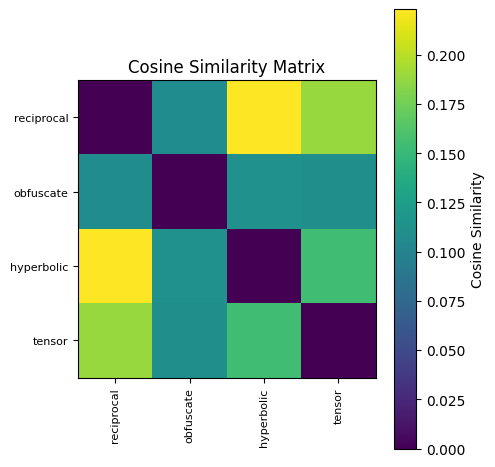

In [ ]:
word_list = ["reciprocal", "obfuscate", "hyperbolic", "tensor"]
word_embeddings = embeddings_model.encode(word_list)
cosine_similarities = cosine_similarity(word_embeddings)
print("Cosine Similarity Matrix:")
print(cosine_similarities)
visualize_similarity_matrix(cosine_similarities, word_list)

## Test Embeddings - related words

Cosine Similarity Matrix:
[[1.0000006  0.5007574  0.44300216]
 [0.5007574  0.9999995  0.53842294]
 [0.44300216 0.53842294 1.0000005 ]]


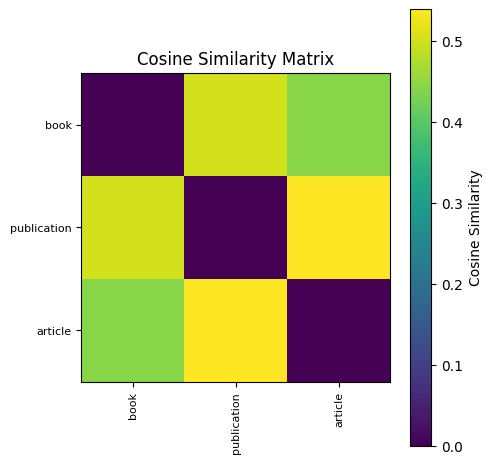

In [ ]:
word_list = ["book", "publication", "article"]
word_embeddings = embeddings_model.encode(word_list)
cosine_similarities = cosine_similarity(word_embeddings)
print("Cosine Similarity Matrix:")
print(cosine_similarities)
visualize_similarity_matrix(cosine_similarities, word_list)

## Calculate normalized mean values of embeddings

In [ ]:
mean_embeddings = np.mean(np.abs(word_embeddings), axis=1)
print("Normalized Mean values of embeddings:", mean_embeddings)
std_embeddings = np.std(word_embeddings, axis=1)
print("Standard Deviation of embeddings:", std_embeddings)
norm_embeddings = np.linalg.norm(word_embeddings, axis=1)
print("Norm of embeddings:", norm_embeddings)

Normalized Mean values of embeddings: [0.03935564 0.03978137 0.04016889]
Standard Deviation of embeddings: [0.05095434 0.05098887 0.05102091]
Norm of embeddings: [1. 1. 1.]


## Generate random vectors with the same mean and std

In [ ]:
random_vectors = np.random.normal(loc=np.mean(word_embeddings),
                                  scale=np.std(word_embeddings),
                                  size=word_embeddings.shape)
mean_random_vectors = np.mean(np.abs(random_vectors), axis=1)
print("Normalized Mean values of random vectors:", mean_random_vectors)
std_random_vectors = np.std(random_vectors, axis=1)
print("Standard Deviation of random vectors:", std_random_vectors)
norm_random_vectors = np.linalg.norm(random_vectors, axis=1)
print("Norm of random vectors:", norm_random_vectors)

Normalized Mean values of random vectors: [0.04212234 0.03949631 0.04029233]
Standard Deviation of random vectors: [0.05243272 0.04989562 0.05069057]
Norm of random vectors: [1.02882538 0.97796409 0.99346674]


Cosine Similarity Matrix random vectors:
[[ 1.         -0.01453459  0.07964734]
 [-0.01453459  1.          0.09268045]
 [ 0.07964734  0.09268045  1.        ]]


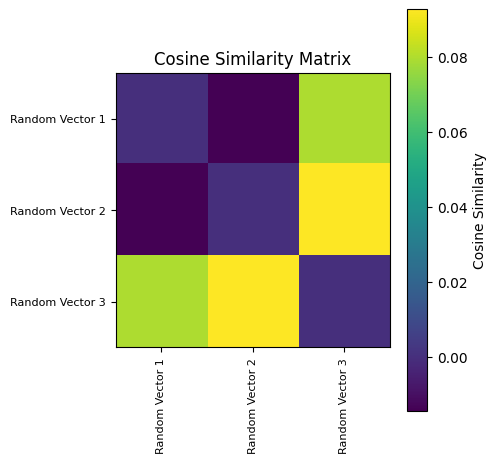

In [ ]:
print("Cosine Similarity Matrix random vectors:")
cosine_similarities = cosine_similarity(random_vectors)
print(cosine_similarities)
visualize_similarity_matrix(cosine_similarities, ["Random Vector 1", "Random Vector 2", "Random Vector 3"])

## car ~ vehicle + motorcycle - bike

In [ ]:
sentences = ["car", "vehicle", "motorcycle", "bike"]
embeddings = embeddings_model.encode(sentences)
print(cosine_similarity(embeddings[0].reshape(1, -1), (embeddings[1] + embeddings[2] - embeddings[3]).reshape(1, -1))[0, 0])

0.7070358


## Greece ~ Athens + Italy - Rome

In [ ]:
sentences = ["Greece", "Athens", "Italy", "Rome"]
embeddings = embeddings_model.encode(sentences)
print(cosine_similarity((embeddings[0]).reshape(1, -1), (embeddings[1]+embeddings[2]-embeddings[3]).reshape(1, -1))[0, 0])

0.6808976


So embeddings work!

## Sentence embeddings

[[ 0.99999994  0.83302605  0.8061519   0.01931087 -0.01545605  0.01715524]
 [ 0.83302605  0.9999998   0.80017054 -0.00155976 -0.01763443  0.00693283]
 [ 0.8061519   0.80017054  1.          0.00830719 -0.03135199 -0.00174032]
 [ 0.01931087 -0.00155976  0.00830719  1.0000001   0.35675752  0.38396105]
 [-0.01545605 -0.01763443 -0.03135199  0.35675752  0.9999999   0.49327666]
 [ 0.01715524  0.00693283 -0.00174032  0.38396105  0.49327666  1.        ]]


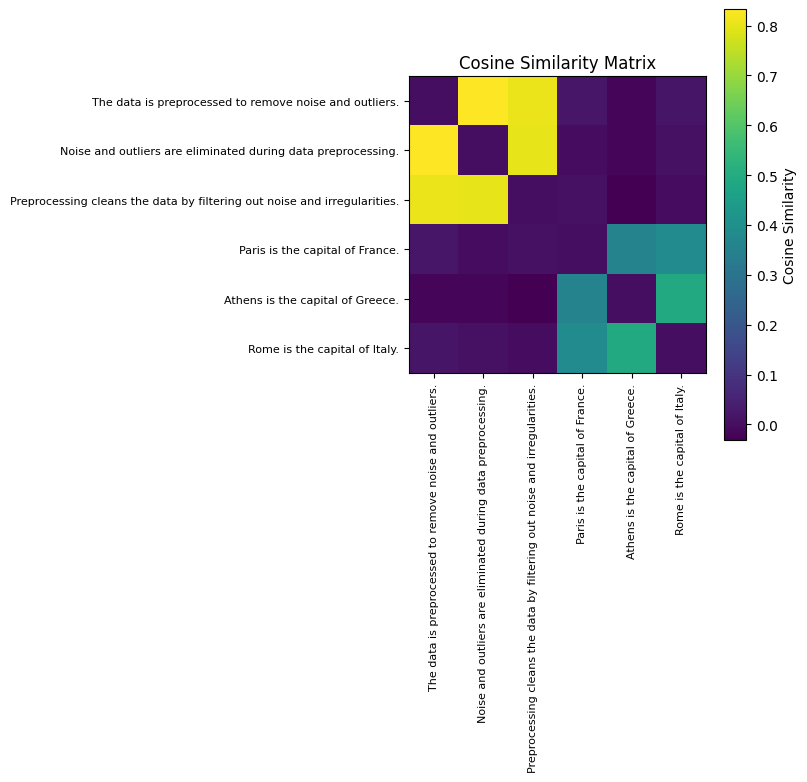

In [ ]:
my_sentences = [
    # Interrelated sentences - group 1
    "The data is preprocessed to remove noise and outliers.",
    "Noise and outliers are eliminated during data preprocessing.",
    "Preprocessing cleans the data by filtering out noise and irregularities.",

    # Interrelated sentences - group 2
    "Paris is the capital of France.",
    "Athens is the capital of Greece.",
    "Rome is the capital of Italy."
]
my_embeddings = embeddings_model.encode(my_sentences)
similarity_matrix = cosine_similarity(my_embeddings)
print(similarity_matrix)
visualize_similarity_matrix(similarity_matrix, my_sentences, mat_size=8)

# Retrieval Augmented Generation (RAG)

In [ ]:
from sentence_transformers import SentenceTransformer
import torch
import numpy as np
import os
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
if torch.cuda.device_count()>0:
    my_device = "cuda"
    print(f"You have {torch.cuda.device_count()} GPUs available.")
else:
    my_device = "cpu"
    print("You have no GPUs available. Running on CPU.")

You have 1 GPUs available.


## Embeddings Model

In [ ]:
embeddings_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2', token=os.environ["HF_TOKEN"],
                                       cache_folder=os.environ["HF_HOME"], device=my_device)

## Text for retrieval

In [ ]:
my_text = """
GRNET announces, in the context of SmartAttica EDIH (European Digital Innovation Hub), the  2nd Module of Τraining modules for SMEs with the subject "Introduction to Large Language Models", that will take place online on March 14th, 2025.

# Date: March 14th, 2025, at 11:00 EET

# Location: Online via Zoom

# Description: This module provides a practical introduction to Large Language Models (LLMs) and their applications, focusing on setting up the necessary computational environment and using the Transformers library. Participants will engage in hands-on activities to download, configure, and utilize LLMs, including generating text and working with embeddings.

# Target Audience: SME professionals and tech enthusiasts interested in understanding and applying large language models in business or technological solutions.

# Learning Objectives:

Understand the fundamental concepts and applications of LLMs.
Set up and configure computational environments for LLM workflows.
Install and use the Transformers library for NLP tasks.
Download and configure language models for various applications.
Generate and interpret text outputs using language models.
Utilize embeddings for tasks like similarity measurement and retrieval-augmented generation.
Gain practical experience through interactive exercises and problem-solving.

# Prerequisites:

Basic programming knowledge
Familiarity with Python
Basic understanding of machine learning concepts.
Note: Please enter your institutional/corporate email when registering.

# Indicative Contents
Introduction to Large Language Models
A brief overview of LLMs and their applications.
Introduction to the seminar structure and objectives.
Setting Up the Environment
Instructions on setting environment variables and necessary tools.
A quick walkthrough on using Colab and accessing GPU resources.
HPC Environment Preparation
Detailed guide on installing dependencies for High-Performance Computing (HPC) environments.
Steps for resource allocation on HPC nodes.
Introduction to the Transformers Library
Explanation of the Transformers library and its components.
Installation of necessary Python packages (transformers, accelerate, etc.).
Downloading and Loading Models
Instructions for downloading models from Hugging Face.
Code demonstration for loading a language model like LLaMa-3.2-1B-Instruct.
Tokenization and Model Configuration
Setting up the tokenizer and handling special tokens like pad_token.
Configuration of the model for causal language modeling tasks.
Interactive Text Generation
Hands-on example of generating text using the model.
Explanation of parameters like max_new_tokens and streaming text outputs.
Understanding and Utilizing Embeddings
Import sentence-transformers and compute embeddings for words/sentences.
Visualizing and interpreting similarity matrices with cosine similarity.
Retrieval-Augmented Generation (RAG)
Overview of RAG and its importance in enhancing model outputs.
Demonstration of extracting relevant information using embedding-based retrieval.
Interactive Q&A and Hands-On Practice
Addressing participant questions.
Encouraging participants to try modifying the code and parameter settings for deeper understanding.
"""

In [ ]:
my_sentences = my_text.split('# ')
my_embeddings = embeddings_model.encode(my_sentences)
print(my_embeddings.shape)

np.savetxt('sentence_embeddings.txt', my_embeddings, delimiter=',')

(8, 384)


## Encode user's question

In [ ]:
my_question = "Which is the target audience?"
my_question_embedding = embeddings_model.encode([my_question])

## Sort sentences based on the similarity to the question embedding

In [ ]:
similarity_to_question = cosine_similarity(my_question_embedding, my_embeddings).flatten()
sorted_indices = similarity_to_question.argsort()[::-1]  # Sort in descending order
print(sorted_indices)

[4 2 3 1 7 0 5 6]


## Get sorted sentences


In [ ]:
sorted_sentences = [my_sentences[i] for i in sorted_indices]
print("Sorted sentences based on cosine similarity to the question:")
for i, sentence in enumerate(sorted_sentences):
    print("-"*100)
    print(f"Sentence {i+1}, similarity: {similarity_to_question[sorted_indices[i]]:.2f}")
    print(sentence)

Sorted sentences based on cosine similarity to the question:
----------------------------------------------------------------------------------------------------
Sentence 1, similarity: 0.45
Target Audience: SME professionals and tech enthusiasts interested in understanding and applying large language models in business or technological solutions.


----------------------------------------------------------------------------------------------------
Sentence 2, similarity: 0.13
Location: Online via Zoom


----------------------------------------------------------------------------------------------------
Sentence 3, similarity: 0.11
Description: This module provides a practical introduction to Large Language Models (LLMs) and their applications, focusing on setting up the necessary computational environment and using the Transformers library. Participants will engage in hands-on activities to download, configure, and utilize LLMs, including generating text and working with embeddings.



## Setup messages
### Keep the 3 most similar and use them to answer the question.

In [ ]:
nof_keep_sentences = 3
system_instructions = f"You are a helful assistant."
my_messages = [{"role": "system", "content": system_instructions}]
my_prompt = f"Use the following sentences:"
for sentence in sorted_sentences[:nof_keep_sentences]:
    my_prompt += f"\n{sentence}"
my_prompt += f"\n\nAnswer the question:\n\n'{my_question}'"
my_messages.append({"role": "user", "content": my_prompt})
my_prompt

"Use the following sentences:\nTarget Audience: SME professionals and tech enthusiasts interested in understanding and applying large language models in business or technological solutions.\n\n\nLocation: Online via Zoom\n\n\nDescription: This module provides a practical introduction to Large Language Models (LLMs) and their applications, focusing on setting up the necessary computational environment and using the Transformers library. Participants will engage in hands-on activities to download, configure, and utilize LLMs, including generating text and working with embeddings.\n\n\n\nAnswer the question:\n\n'Which is the target audience?'"

## Answer the question

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, TextStreamer
import os
my_model = "meta-llama/Llama-3.2-1B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(my_model,
                                          token=os.environ["HF_TOKEN"],
                                          cache_dir=os.environ["HF_HOME"])
model = AutoModelForCausalLM.from_pretrained(   my_model,
                                                token=os.environ["HF_TOKEN"],
                                                cache_dir=os.environ["HF_HOME"],
                                                device_map="auto")

In [ ]:
# Depending on the model, the pad token might not be defined
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    print("Pad token was None, so it was set to eos token.")

streamer = TextStreamer(tokenizer)

pipe = pipeline("text-generation",
                model=model,
                tokenizer=tokenizer,
                device_map="auto")
MAXIMUM_TOKENS = 128
outputs = pipe(my_messages,
               max_new_tokens=MAXIMUM_TOKENS,
               pad_token_id=pipe.tokenizer.eos_token_id,
               streamer=streamer)

Device set to use cuda:0


Pad token was None, so it was set to eos token.
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 13 Mar 2025

You are a helful assistant.<|eot_id|><|start_header_id|>user<|end_header_id|>

Use the following sentences:
Target Audience: SME professionals and tech enthusiasts interested in understanding and applying large language models in business or technological solutions.


Location: Online via Zoom


Description: This module provides a practical introduction to Large Language Models (LLMs) and their applications, focusing on setting up the necessary computational environment and using the Transformers library. Participants will engage in hands-on activities to download, configure, and utilize LLMs, including generating text and working with embeddings.



Answer the question:

'Which is the target audience?'<|eot_id|><|start_header_id|>assistant<|end_header_id|>

The target audience for this module is SME professionals an

In [ ]:
print(outputs[0]["generated_text"][-1]['content'])

The target audience for this module is SME professionals and tech enthusiasts interested in understanding and applying large language models in business or technological solutions.
